# Punto 3

## Librerías utilizadas

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import roc_curve
import seaborn as sns

Iniciamos cargando nuestros conjuntos de datos.

In [10]:
data = pd.read_csv('balanced_final_transaction.csv')
data.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD_S,ProductCD_R,M6_T,M1_F,card2,card3,C3,C5,D3,D4,D11,isFraud
0,2987000,86400,68.5,0.0,0.0,1.0,0.0,361.0,150.0,0.0,0.0,13.0,26.0,13.0,0
1,2987001,86401,29.0,0.0,0.0,1.0,0.0,404.0,150.0,0.0,0.0,8.0,0.0,43.0,0
2,2987002,86469,59.0,0.0,0.0,0.0,0.0,490.0,150.0,0.0,0.0,8.0,0.0,315.0,0
3,2987003,86499,50.0,0.0,0.0,0.0,0.0,567.0,150.0,0.0,0.0,0.0,94.0,43.0,0
4,2987004,86506,50.0,0.0,0.0,0.0,0.0,514.0,150.0,0.0,0.0,8.0,26.0,43.0,0


Luego de realizar el EDA de estos conjuntos de datos se decidió ajustar los modelos predictivos con las siguientes variables:

- Variables explicativas: TransactionID, TransactionDT,	TransactionAmt,	ProductCD_S, ProductCD_R, M6_T,	M1_F, card2,	card3, C3, C5, D3, D4, D11
- Variable respuesta: isFraud

Como ya tenemos establecido cuál será el conjunto de datos que utilizaremos para entrenar los modelos de clasificación, procedemos a construir el Pipeline. Además, escogió una validación cruzada estratificada ya que nos interesa que en cada partición quede la misma proporción de etiquetas.

In [11]:
X = data.drop(columns=['isFraud'])
y = data['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

Evaluating LogisticRegression...


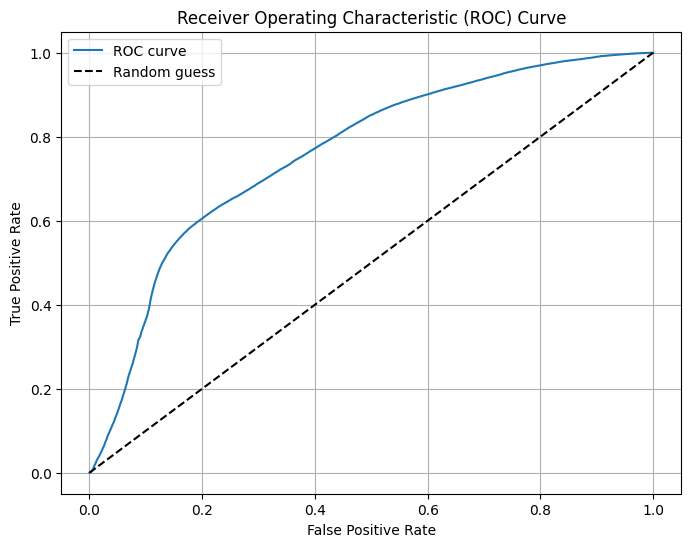

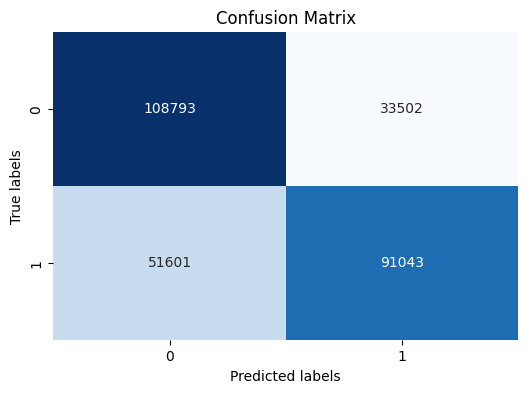

entre
Model: LogisticRegression
AUC: 0.7608517651616016
Best Parameters:
{'clf__C': 0.1}
Classification Report:
              precision    recall  f1-score   support

   Not Fraud       0.68      0.76      0.72    142295
       Fraud       0.73      0.64      0.68    142644

    accuracy                           0.70    284939
   macro avg       0.70      0.70      0.70    284939
weighted avg       0.70      0.70      0.70    284939





In [12]:
pipelines = {
    'LogisticRegression': Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression())]),
}

param_grids = {
    "LogisticRegression": {"clf__C": [0.1, 1, 10, 100]}
}

results = {}
for model_name, pipeline in pipelines.items():
    print(f"Evaluating {model_name}...")
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(pipeline, param_grid=param_grids[model_name], cv=skf, scoring='roc_auc')
    
    try:
        grid_search.fit(X_train, y_train)
        y_pred = grid_search.predict(X_test)
        y_prob = grid_search.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_prob)
        cm = confusion_matrix(y_test, y_pred)
        report = classification_report(y_test, y_pred, target_names=['Not Fraud', 'Fraud'])
        results[model_name] = {'AUC': auc, 'Confusion Matrix': cm, 'Classification Report': report, 'Best Parameters': grid_search.best_params_}

        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label='ROC curve')
        plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='best')
        plt.grid(True)
        plt.show()
        
        # Graficar la matriz de confusión
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.show()

    except Exception as e:
        print(f"Error evaluating {model_name}: {e}")


for model_name, result in results.items():
    print('entre')
    print(f"Model: {model_name}")
    print(f"AUC: {result['AUC']}")
    print("Best Parameters:")
    print(result['Best Parameters'])
    print("Classification Report:")
    print(result['Classification Report'])
    print("\n")
    
    

Debido a los altos costos computacionales que requería el entrenamiento del modelo KNN no fue posible incluirlo en este trabajo, ya que cuando se entrenaban el modelo la memoria disponible colapsaba, es por esto que solo se incluyó el modelo de regresión logística.

En conclusión, se puede observar que el modelo de regresión logística con un AUC de 0.7608, el modelo tiene una capacidad razonable para distinguir entre las clases de Fraude y No Fraude. Además, de todas las transacciones que el modelo predijo como fraude, el 73% realmente son fraudes. Asimismo, el modelos pudo identificar correctamente el 64% de todas las transacciones fraudulentas. Por último, F1-score no indica que para la clase "fraude" es del 68%, lo que indica un equilibrio entre la precisión y el recall para esta clase.